In [2]:
from pathlib import Path
from datetime import datetime
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from reproducible_figures import (
    save_reproducible_figure, set_plotting_style
)

In [8]:
EXPERIMENT_FOLDER = "./experiments/subset_permutation/07-10_02-11"
NUM_CLASSES = 3
CHANNEL_SIZE = 5

In [11]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.vary_play_param_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *


NUM_CLASSES = 3
CHANNEL_SIZE = 5
BATCH_SIZE = 32

TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)


def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def create_channel_subset_permutation_experiment(
    permutation_subset_size=3, **experiment_kwargs
):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': permutation_subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        lr=1e-2,
        name='channel_subset_permutation',
        **experiment_kwargs
    )

2024-04-22 18:27:38.644292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 18:27:38.682092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 18:27:38.682114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 18:27:38.683256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 18:27:38.689581: I tensorflow/core/platform/cpu_feature_guar

In [12]:
experiment = VaryPlayParamExperiment(
    save_location=EXPERIMENT_FOLDER,
    param_vals=[2, 3, 4, 5],
    param_name='permutation_subset_size',
    max_epochs=200,
    num_experiments_per_val=3,
    create_experiment_fn=create_channel_subset_permutation_experiment
)

2024-04-22 18:27:57.468764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:27:57.509729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:27:57.509780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:27:57.519811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:27:57.519882: I external/local_xla/xla/stream_executor

In [14]:
for meta_path in Path(EXPERIMENT_FOLDER).glob('*'):
    experiment.load_meta_exp(meta_path)

In [26]:
exp.get_play_params()

{'channel_size': 5,
 'p_mutate': 0,
 'message_permutation': True,
 'permutation_subset_size': 2,
 'channel_temp': 0.1}

'meta_experiment_permutation_subset_size=2'

In [29]:
responsiveness_vals = []

for meta_idx, meta_exp_item in enumerate(experiment.experiments):
    meta_exp = meta_exp_item['experiment']
    for exp_idx, exp_item in enumerate(meta_exp.experiments):
        exp = exp_item['experiment']
        responsiveness_vals.append({
            'Student Responsiveness': exp.compute_student_responsiveness(),
            'Teacher Responsiveness': exp.compute_teacher_responsiveness(),
            'Meta Experiment Index': meta_idx,
            'Experiment Index': exp_idx,
            **exp.get_play_params()
        })

responsiveness_df = pd.DataFrame(responsiveness_vals)

In [36]:
X_NAME = 'Permuted Proportion'


def get_experiment_item(experiment_path):
    with open(experiment_path / 'results.json', 'r') as f:
        results = json.load(f)
    with open(experiment_path / 'meta.json', 'r') as f:
        config = json.load(f)
    permutation_subset_size = config['experiment_config']['play_params']['permutation_subset_size']

    return [
        {
            X_NAME: permutation_subset_size,
            'Zero-Shot Coordination Score': sub_item['mean_ground_truth_f1'],
            'Protocol Diversity': sub_item['mean_protocol_diversity'],
            **sub_item
        }
        for item in results
        for sub_item in item['vanilla_params_test_metrics']
    ]

zs_coord_df = pd.DataFrame([
    item
    for experiment_path in Path(EXPERIMENT_FOLDER).glob('*')
    for item in get_experiment_item(experiment_path)
])
zs_coord_df.head()

,Permuted Proportion,Zero-Shot Coordination Score,Protocol Diversity,mean_test_loss,mean_ground_truth_f1,ground_truth_acc,mean_student_error,mean_teacher_error,mean_protocol_diversity,mean_protocol_entropy
0,5,1.00000,1.0,1.192093e-07,1.00000,1.00000,6.715874e-01,0.233789,1.0,7.222242e-35
1,5,1.00000,1.0,1.192093e-07,1.00000,1.00000,1.678968e+00,0.291309,1.0,7.222242e-35
2,5,0.96250,1.0,3.033515e-01,0.96250,0.96250,2.358137e-01,0.181484,1.0,7.222242e-35
3,5,1.00000,1.0,1.192093e-07,1.00000,1.00000,1.192093e-07,0.002658,1.0,7.222242e-35
4,5,0.88125,1.0,1.914024e+00,0.88125,0.88125,1.271623e+00,0.234793,1.0,7.222242e-35


In [32]:
responsiveness_df[X_NAME] = responsiveness_df['permutation_subset_size']

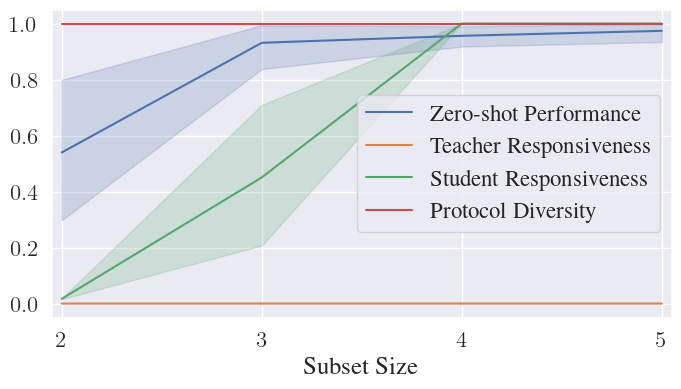

reformatted figures/subset_permutation_experiments_metrics/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [35]:
def plot_metrics_with_subset_size(zs_coord_df, responsiveness_df):
    set_plotting_style()

    plt.figure(figsize=(8, 4))

    sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                data=zs_coord_df, label='Zero-shot Performance')
    sns.lineplot(x=X_NAME, y='Teacher Responsiveness', 
                data=responsiveness_df, label='Teacher Responsiveness')
    sns.lineplot(x=X_NAME, y='Student Responsiveness', 
                data=responsiveness_df, label='Student Responsiveness')
    sns.lineplot(x=X_NAME, y='Protocol Diversity', 
                data=zs_coord_df, label='Protocol Diversity')

    plt.ylim([-0.05, 1.05])

    plt.xlim([1.95, CHANNEL_SIZE + .05])
    # plt.title('The Effect of Channel Permutation on Zero-Shot Coordination')
    plt.ylabel('')
    plt.xlabel('Subset Size')
    plt.xticks(pd.unique(zs_coord_df[X_NAME]))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc=4)
# plt.show()


save_reproducible_figure(
    'subset_permutation_experiments_metrics',
    (zs_coord_df, responsiveness_df),
    plot_metrics_with_subset_size,
    show=True
)